# Task 2 : Forward Kinematics

In [1]:
import modern_robotics as mr
import numpy as np

np.set_printoptions(suppress=True)
from dataclasses import dataclass
from tpk4170.visualization import Kr6R900SixxVisualizer

## Visualize Denavit-Hartenberg frames

### 1) Definitions

In [2]:
@dataclass
class DHLink:
    a: float
    alpha: float
    d: float
    theta: float

    def matrix(self) -> np.array:
        ct = np.cos(self.theta)
        st = np.sin(self.theta)
        ca = np.cos(self.alpha)
        sa = np.sin(self.alpha)
        return np.array(
            [
                [ct, -st * ca, st * sa, self.a * ct],
                [st, ct * ca, -ct * sa, self.a * st],
                [0.0, sa, ca, self.d],
                [0.0, 0.0, 0.0, 1.0],
            ]
        )

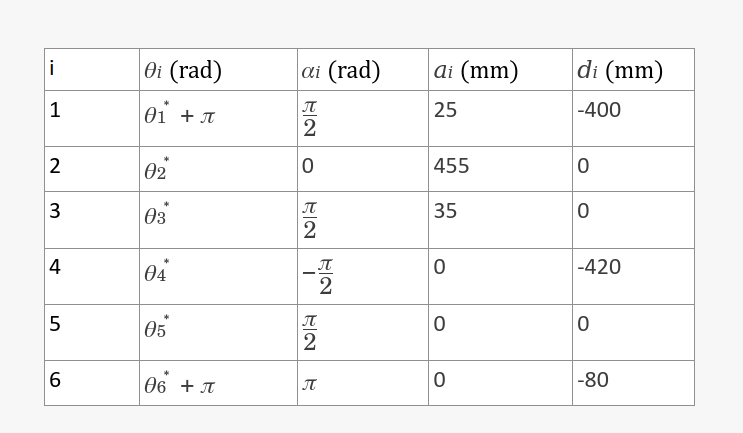

In [3]:
# define DH parameters for each link in meters

PI = np.pi
PI_HALF = np.pi/2

#joint variables
theta = [0, 0, 0, 0, 0, 0]

# format : (a, alpha, d, theta)

l1 = DHLink(0.025, PI_HALF,  -0.400, theta[0]+PI)
l2 = DHLink(0.455, 0.0,      0.0,    theta[1])
l3 = DHLink(0.035, PI_HALF,  0.0,    theta[2]-PI_HALF)
l4 = DHLink(0.0,   -PI_HALF, -0.420, theta[3])
l5 = DHLink(0.0,   PI_HALF,  0.0,    theta[4])
l6 = DHLink(0.0,   PI,       -0.080, theta[5]+PI)


### 2) Visualization of DH frames

In [4]:
from tpk4170.visualization import Viewer
from tpk4170.models import Grid, Axes
from pythreejs import Object3D
from transformations import quaternion_from_matrix

In [5]:
class DHFrame(Axes):
    def __init__(self, trf):
        Axes.__init__(self, 0.1)
        self.quaternion = np.roll(quaternion_from_matrix(trf), -1).tolist()
        self.position = (trf[:3, 3]).tolist()

In [6]:
# show the KR6 visualization as a comparison
kr6_vis = Kr6R900SixxVisualizer()
kr6_vis.theta = np.array([0, 0, PI_HALF, 0, 0, 0])

/home/gaston/Desktop/tpk4170-robotics/tpk4170_venv/lib/python3.8/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [7]:
viewer = Viewer(background="white")

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [8]:
# Since the visualization base frame is not the same as the 0 frame that we choose for DH,
# we need to apply a transformation T0v to all matrices in order to visualize them

T0v = np.array([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]
               ])

T01 = np.linalg.inv(T0v) @ l1.matrix()
T02 = np.linalg.inv(T0v) @ l1.matrix() @ l2.matrix()
T03 = np.linalg.inv(T0v) @ l1.matrix() @ l2.matrix() @ l3.matrix()
T04 = np.linalg.inv(T0v) @ l1.matrix() @ l2.matrix() @ l3.matrix() @ l4.matrix()
T05 = np.linalg.inv(T0v) @ l1.matrix() @ l2.matrix() @ l3.matrix() @ l4.matrix() @ l5.matrix()
T06 = np.linalg.inv(T0v) @ l1.matrix() @ l2.matrix() @ l3.matrix() @ l4.matrix() @ l5.matrix() @ l6.matrix()

In [9]:
viewer.add(Grid())
viewer.add(DHFrame(T0v))
viewer.add(DHFrame(T01))
viewer.add(DHFrame(T02))
viewer.add(DHFrame(T03))
viewer.add(DHFrame(T04))
viewer.add(DHFrame(T05))
viewer.add(DHFrame(T06))

## Visualize space frame and body frame screw axes

In [10]:
from pythreejs import ArrowHelper as Arrow

In [11]:
class ScrewAxis(Arrow):
    def __init__(self, direction, origin, length=.5):
        Arrow.__init__(self, direction.tolist(), origin.tolist(), length, hex=0xffff00)
        

In [12]:
class Kr6:
    def __init__(self):
        self._M = np.array(
            [
                [0.0, 0.0, -1.0, -0.980],
                [0.0, 1.0, 0.0, 0],
                [1.0, 0.0, 0.0, -0.435], 
                [0.0, 0.0, 0.0, 1.0],
            ]
        )
        
        self._SList = np.array(
            [
                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.400, 0.0, -0.025],
                [0.0, 1.0, 0.0, 0.400, 0.0, -0.480],
                [1.0, 0.0, 0.0, 0.0, -0.435, 0.0],
                [0.0, 1.0, 0.0, 0.435, 0.0, -0.900],
                [1.0, 0.0, 0.0, 0.0, -0.435, 0.0]
            ]
        ).T
        
    def fkin(self, theta):
        return mr.FKinSpace(self._M, self._SList, theta)


PI_HALF = np.pi / 2
PI = np.pi

kr6 = Kr6()

In [13]:
v = Kr6R900SixxVisualizer()
v.theta = np.array([0, 0, 0, 0, 0, 0])

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [14]:
#rotation matrix from space frame to visualizer base frame
R_sv = np.array([[-1, 0, 0],
                 [0, 1, 0],
                 [0, 0, -1]]
               )

In [15]:
w1 = R_sv @ kr6._SList.T[0][:3]
p1 = np.array([0, 0, 0])
s1_rep = ScrewAxis(w1, p1)

w2 = R_sv @ kr6._SList.T[1][:3]
p2 = R_sv @ np.array([-0.025, 0, -0.400])
s2_rep = ScrewAxis(w2, p2)

w3 = R_sv @ kr6._SList.T[2][:3]
p3 = R_sv @ np.array([-0.480, 0, -0.400])
s3_rep = ScrewAxis(w3, p3)

w4 = R_sv @ kr6._SList.T[3][:3]
p4 = R_sv @ np.array([0, 0, -.435])
s4_rep = ScrewAxis(w4, p4)

w5 = R_sv @ kr6._SList.T[4][:3]
p5 = R_sv @ np.array([-0.900, 0, -0.435])
s5_rep = ScrewAxis(w5, p5)

w6 = R_sv @ kr6._SList.T[5][:3]
p6 = R_sv @ np.array([0, 0, -.435])
s6_rep = ScrewAxis(w3, p3)




v._viewer.add(s1_rep)
v._viewer.add(s2_rep)
v._viewer.add(s3_rep)
v._viewer.add(s4_rep)
v._viewer.add(s5_rep)
v._viewer.add(s6_rep)

## Verification that DH agrees with PoE

Let's take 3 different joint positions to check if they agree:
- $\theta^A = \left[\;\begin{matrix}
                    \pi/2 & -\pi/2 & \pi/3 & 0 & 0 & 0
                    \end{matrix} \; \right]^T$

- $\theta^B = \left[\;\begin{matrix}
                    0 & 5 \pi/4 & \pi/4 & 0 & \pi/3 & \pi/5 
                    \end{matrix} \; \right]^T$

- $\theta^C = \left[\;\begin{matrix}
                    \pi/5 & -\pi/4 & \pi/3 & \pi/3 & -\pi/3 & 0
                    \end{matrix} \; \right]^T$

In [16]:
theta_A = [PI/2, -PI/2, PI/3, 0, 0, 0]
theta_B = [0, 5*PI/4, PI/4, 0, PI/3, PI/5]
theta_C = [PI/5, -PI/4, PI/3, PI/3, -PI/3, 0]

In [17]:
def dhFKin(theta):
    l1 = DHLink(0.025, PI_HALF,  -0.400, theta[0]+PI)
    l2 = DHLink(0.455, 0.0,      0.0,    theta[1])
    l3 = DHLink(0.035, PI_HALF,  0.0,    theta[2]-PI/2) #expliquer -PI/2
    l4 = DHLink(0.0,   -PI_HALF, -0.420, theta[3])
    l5 = DHLink(0.0,   PI_HALF,  0.0,    theta[4])
    l6 = DHLink(0.0,   PI,       -0.080, theta[5]+PI)

    return l1.matrix() @ l2.matrix() @ l3.matrix() @ l4.matrix() @ l5.matrix() @ l6.matrix()

In [18]:
# DH
T_dh_A = dhFKin(theta_A)

# PoE
T_poe_A = kr6.fkin(theta_A)

np.allclose(T_dh_A, T_poe_A)

True

In [19]:
# DH
T_dh_B = dhFKin(theta_B)

# PoE
T_poe_B = kr6.fkin(theta_B)

np.allclose(T_dh_B, T_poe_B)

True

In [20]:
# DH
T_dh_C = dhFKin(theta_C)

# PoE
T_poe_C = kr6.fkin(theta_C)

np.allclose(T_dh_C, T_poe_C)

True